copied from : https://www.kaggle.com/c/riiid-test-answer-prediction/data
# train.csv

**row_id**: (int64) ID code for the row.

**timestamp**: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

**user_id**: (int32) ID code for the user.

**content_id**: (int16) ID code for the user interaction

**content_type_id**: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

**task_container_id**: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

**user_answer**: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

**answered_correctly**: (int8) if the user responded correctly. Read -1 as null, for lectures.

**prior_question_elapsed_time**: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

**prior_question_had_explanation**: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

# questions.csv: metadata for the questions posed to users.

**question_id**: foreign key for the train/test content_id column, when the content type is question (0).

**bundle_id**: code for which questions are served together.

**correct_answer**: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

**part**: the relevant section of the TOEIC test.

**tags**: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

# lectures.csv: metadata for the lectures watched by users as they progress in their education.

**lecture_id**: foreign key for the train/test content_id column, when the content type is lecture (1).

**part**: top level category code for the lecture.

**tag**: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

**type_of**: brief description of the core purpose of the lecture


In [1]:
#jupyter notebook --NotebookApp.max_buffer_size=16106127360
#https://www.kaggle.com/c/riiid-test-answer-prediction/data
import pandas as pd
import numpy as np

In [2]:
example_sample_submission = "data/example_sample_submission.csv"
example_test = "data/example_test.csv"
lectures = "data/lectures.csv"
questions = "data/questions.csv"


pd_example_sample_submission  = pd.read_csv(example_sample_submission,low_memory=False)
pd_example_test = pd.read_csv(example_test,low_memory=False)
pd_lectures = pd.read_csv(lectures,low_memory=False)
pd_questions = pd.read_csv(questions,low_memory=False)


In [12]:
train = "data/train.csv"
pd_train = pd.read_csv(train)

In [13]:
selected_train = "data/selected_train.csv"
pd_selected_train = pd.read_csv(selected_train,low_memory=False)
pd_selected_train_answers = pd_selected_train[pd_selected_train["answered_correctly"]!=-1]

In [2]:
pd_train.describe()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07
mean,5.061517e+07,7.703644e+09,1.076732e+09,5.219605e+03,1.935222e-02,9.040624e+02,1.376123e+00,6.251644e-01,2.542381e+04
std,2.922268e+07,1.159266e+10,6.197163e+08,3.866359e+03,1.377596e-01,1.358302e+03,1.192896e+00,5.225307e-01,1.994815e+04
min,0.000000e+00,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,2.530758e+07,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04
50%,5.061517e+07,2.674234e+09,1.071781e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04
75%,7.592275e+07,9.924551e+09,1.615742e+09,7.425000e+03,0.000000e+00,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04
max,1.012303e+08,8.742577e+10,2.147483e+09,3.273600e+04,1.000000e+00,9.999000e+03,3.000000e+00,1.000000e+00,3.000000e+05


In [ ]:
pd_example_sample_submission.head(5)

In [16]:
pd_train_answers =  pd_train[pd_train["answered_correctly"]!=-1]

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

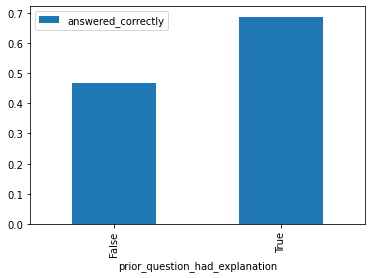

In [25]:


# Discovery of the train set.

# not perfect percentage because there is -1 values
pd_influence_prior = pd_selected_train_answers.groupby('prior_question_had_explanation')['answered_correctly'].agg(answered_correctly='mean')
pd_influence_prior.plot.bar(y="answered_correctly")

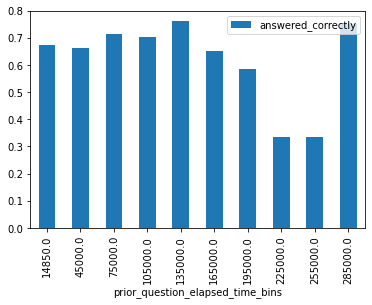

In [26]:
binned_prior_question_elapsed_time = pd.cut(pd_selected_train_answers["prior_question_elapsed_time"],10).apply(lambda x:x.mid)
pd_selected_train_answers.loc[:,"prior_question_elapsed_time_bins"] = binned_prior_question_elapsed_time
pd_influence_prior_question_elapsed_time = pd_selected_train_answers.groupby('prior_question_elapsed_time_bins')['answered_correctly'].agg(answered_correctly='mean')
pd_influence_prior_question_elapsed_time.plot.bar(y="answered_correctly")

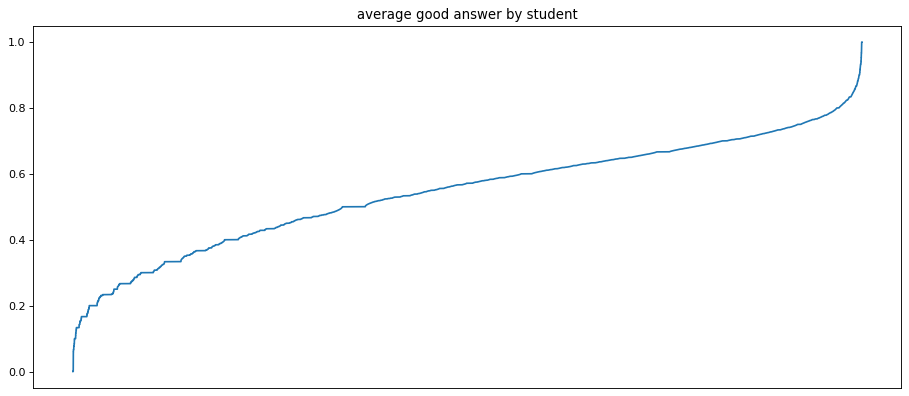

<Figure size 432x288 with 0 Axes>

In [7]:
pd_mean_student = pd_train_answers.groupby('user_id')['answered_correctly'].agg(mean_answered_correctly='mean')
pd_mean_student = pd_mean_student.sort_values("mean_answered_correctly")



figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(len(pd_mean_student)),pd_mean_student["mean_answered_correctly"],)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title("average good answer by student")
plt.show()
plt.clf()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,count_question_x,count_question_y,count_question
0,0,0,115,5692,0,1,3,1,NaN,NaN,36514,36514,36514
1,2385,4216576228,24418,5692,0,497,3,1,21000.0,True,36514,36514,36514
2,8954,0,51285,5692,0,0,3,1,NaN,NaN,36514,36514,36514
3,9280,330907575,91216,5692,0,153,3,1,22000.0,True,36514,36514,36514
4,13269,560202977,138650,5692,0,122,3,1,18000.0,True,36514,36514,36514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99271295,89256667,7327293505,1896513376,5823,0,4239,0,1,21000.0,True,1,1,1
99271296,97579050,4339553896,2070144393,10008,0,1406,3,1,23750.0,False,1,1,1
99271297,97579051,4339553896,2070144393,10007,0,1406,1,0,23750.0,False,1,1,1
99271298,97579052,4339553896,2070144393,10006,0,1406,0,1,23750.0,False,1,1,1


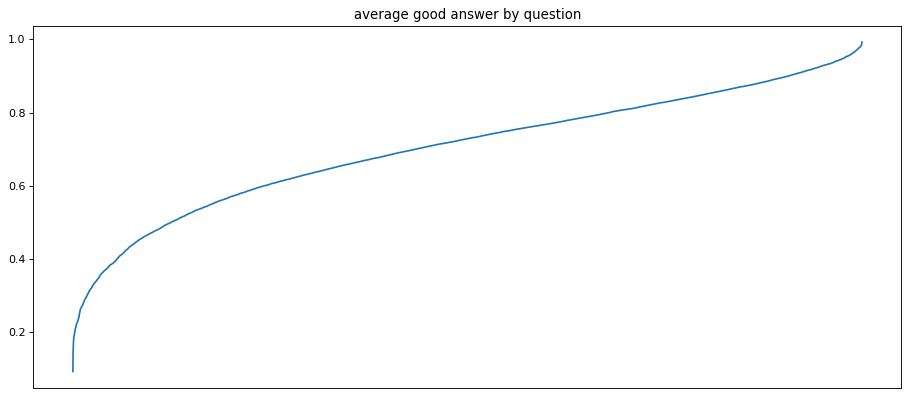

<Figure size 432x288 with 0 Axes>

In [17]:
pd_number_of_exemple_by_question = pd_train_answers.groupby('content_id')["content_id"].agg(count_question="count")
pd_train_answers = pd_train_answers.merge(pd_number_of_exemple_by_question,right_on="content_id",left_on="content_id")
question_difficulty = pd_train_answers[pd_train_answers["count_question"]>200].groupby('content_id')['answered_correctly'].agg(mean_answered_correctly='mean')
question_difficulty = question_difficulty.sort_values("mean_answered_correctly")

figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(len(question_difficulty)),question_difficulty["mean_answered_correctly"],)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title("average good answer by question")
plt.show()
plt.clf()

In [30]:
bottom_five_questions = question_difficulty.head(5)
top_five_questions = question_difficulty.tail(5)
bottom_five_questions = bottom_five_questions.merge(pd_number_of_exemple_by_question,right_on="content_id",left_on="content_id")
top_five_questions = top_five_questions.merge(pd_number_of_exemple_by_question,right_on="content_id",left_on="content_id")
print("bottom_five_questions\n",bottom_five_questions)
print("top_five_questions\n",top_five_questions)

bottom_five_questions
             mean_answered_correctly  count_question
content_id                                         
10062                      0.091752            7444
7639                       0.100607            8399
3125                       0.135965           10157
9220                       0.144753           12359
7487                       0.147680            9419
top_five_questions
             mean_answered_correctly  count_question
content_id                                         
12444                      0.986842             228
1679                       0.989349            6948
10440                      0.990579            5732
12515                      0.991031             223
10626                      0.992656            5719


In [4]:
pd_enriched_questions.head()

NameError: name 'pd_enriched_questions' is not defined

In [29]:
pd_enriched_questions = pd_questions.merge(question_difficulty,left_on="question_id",right_on="content_id")
pd_enriched_questions["tags"] = pd_enriched_questions["tags"].apply(lambda x:x.split(' '))

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb_tags = MultiLabelBinarizer()
pd_transformed = mlb_tags.fit_transform(pd_enriched_questions.tags)
col = ["tags_"+x for x in mlb_tags.classes_]
pd_enriched_questions = pd_enriched_questions.join(pd.DataFrame(pd_transformed, columns=col))

from sklearn.preprocessing import LabelBinarizer
jobs_encoder = LabelBinarizer()
transformed = jobs_encoder.fit_transform(pd_enriched_questions['part'])
col = ["part_"+str(x+1) for x in range(transformed.shape[1])]
ohe_df = pd.DataFrame(transformed,columns=col)
pd_enriched_questions = pd.concat([pd_enriched_questions, ohe_df], axis=1).drop(['part'], axis=1)


In [31]:
pd_enriched_questions


,question_id,bundle_id,correct_answer,tags,mean_answered_correctly,tags_0,tags_1,tags_10,tags_100,tags_101,...,tags_97,tags_98,tags_99,part_1,part_2,part_3,part_4,part_5,part_6,part_7
0,0,0,0,"[51, 131, 162, 38]",0.907721,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1,"[131, 36, 81]",0.890646,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2,2,0,"[131, 101, 162, 92]",0.554281,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,3,3,0,"[131, 149, 162, 29]",0.779437,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4,4,3,"[131, 5, 162, 38]",0.613215,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12500,13518,13518,3,[14],0.786866,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12501,13519,13519,3,[8],0.571429,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12502,13520,13520,2,[73],0.672474,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12503,13521,13521,0,[125],0.808046,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


(12505, 7)

In [112]:
pd_enriched_questions.head()

,question_id,bundle_id,correct_answer,part,tags,mean_answered_correctly,0,1,10,100,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,1,"[51, 131, 162, 38]",0.907721,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,"[131, 36, 81]",0.890646,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,0,1,"[131, 101, 162, 92]",0.554281,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,3,0,1,"[131, 149, 162, 29]",0.779437,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,3,1,"[131, 5, 162, 38]",0.613215,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
print(pd_enriched_questions.columns)

Index(['question_id', 'bundle_id', 'correct_answer', 'part', 'tags',
       'mean_answered_correctly', '0', '1', '10', '100',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=194)


In [72]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
regressor = RandomForestRegressor(n_estimators=200, random_state=0)
clf = svm.SVC(kernel='linear', C=1)

In [114]:
Xcol = ["question_id","bundle_id","correct_answer","mean_answered_correctly","tags"]
X = pd_enriched_questions.drop(Xcol, axis=1).to_numpy()
Ycol = "mean_answered_correctly"
y = pd_enriched_questions[Ycol].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [115]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



Mean Absolute Error: 0.12415394651336734
Mean Squared Error: 0.025487431925249646
Root Mean Squared Error: 0.15964783720818032


Les résultats ne sont pas parfait mais si l'on rencontre une nouvelle question on pourra grace aux tags lui donner un pourcentage de réussite moyen.

[0.64559281 0.75897475 0.79838722 ... 0.69438936 0.79846912 0.62889998]
